In [ ]:
# !apt-get install pciutils

In [51]:
!nvidia-smi

Fri Nov 12 08:40:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |   1003MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !lscpu | egrep 'Model name|Socket|Thread|NUMA|CPU\(s\)'

CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Socket(s):           1
NUMA node(s):        1
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
NUMA node0 CPU(s):   0-3


In [ ]:
# !lspci | grep VGA

00:03.0 Non-VGA unclassified device: Red Hat, Inc. Virtio SCSI


In [52]:
!pip install optuna

In [53]:
import optuna
#from optuna import Trial
from optuna.samplers import TPESampler

In [54]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0' # 사용하려는 GPU 번호
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import IPython.display as ipd
%matplotlib inline

In [55]:
SCALE = False

In [75]:
# ===DATA===
trainset = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/train.csv')
testset = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/sample_submission.csv')

In [79]:
# 4. Calculate humidex
def humidex(tmp, hum):
    result = 0.81*tmp + 0.01*hum * (0.99* tmp - 14.3) + 46.3
    return result

def holiday_cat(week_day):
  if week_day in [6] :
    return 1
  else :
    return 0

def split_date(df):
    '''
    args
        df: 원본 데이터프레임
    return
        year, month, day, week, weekday 정보를 추가한 dataframe
    '''
    df['year'] = pd.to_datetime(df['date_time']).dt.year
    df['month'] = pd.to_datetime(df['date_time']).dt.month
    df['day'] = pd.to_datetime(df['date_time']).dt.day
    df['week'] = pd.to_datetime(df['date_time']).dt.week
    df['weekday'] = pd.to_datetime(df['date_time']).dt.weekday
    df['humidex'] = df.apply(lambda x : humidex(x['high_temp'], x['humidity']), axis=1)
    df['sun'] = df.apply(lambda x : holiday_cat(x['weekday']), axis = 1)
    df['ideal'] = df[['high_temp', 'wind_speed']].apply(lambda x: (0, 1)[x['high_temp'] > 24 and x['wind_speed'] < 30], axis = 1)
    # df['quarter'] = pd.to_datetime(df['date_time']).dt.quarter # 데이터는 모두 동일 분기 데이터이므로 무의미
    
    return df.drop(columns=['date_time'])

In [80]:
traindf = split_date(trainset)
testdf = split_date(testset)

In [81]:
traindf.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,week,weekday,humidex,sun,ideal
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,13,6,68.177500,1,0
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,14,0,64.839468,0,0
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,14,1,59.352046,0,0
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,14,2,54.841094,0,0
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,14,3,51.802038,0,0


In [82]:
keys = traindf.drop(columns=['number_of_rentals']).keys()

In [83]:
keydict = dict()
for i, k in enumerate(keys):
    keydict[i]=k

In [84]:
X = np.array(traindf.drop(columns=['number_of_rentals'])).astype(float)
y = np.array(traindf['number_of_rentals']).astype(float)
X_test = np.array(testdf).astype(float)

if SCALE:
    x_max = np.max(X, 0)
    y_max = np.max(y, 0)
    X /= x_max
    y /= y_max
    X_test /= x_max

In [85]:
def nmae(true, pred):
    return np.mean(np.abs(true-pred)/true)

In [86]:
def cv(model, X=X, y=y, cnt=100, test_size=.5):
    score = list()
    seeds = np.random.choice(np.arange(1e5), size=cnt, replace=False)
    for seed in seeds:
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        if SCALE:
            y_pred *= y_max
            y_valid *= y_max
        score.append(nmae(y_valid, y_pred))
    return np.mean(score)

In [87]:
def select_features(X, cols):
    _X = list()
    for c in cols:
        _X.append(np.expand_dims(X[:, c],-1))
    return np.concatenate(_X, axis=1)

In [88]:
keydict

{0: 'wind_direction',
 1: 'sky_condition',
 2: 'precipitation_form',
 3: 'wind_speed',
 4: 'humidity',
 5: 'low_temp',
 6: 'high_temp',
 7: 'Precipitation_Probability',
 8: 'year',
 9: 'month',
 10: 'day',
 11: 'week',
 12: 'weekday',
 13: 'humidex',
 14: 'sun',
 15: 'ideal'}

In [89]:
from xgboost import XGBRegressor as Model

In [90]:
def NMAE(true, pred):
    return np.mean(np.abs(true-pred) / true)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
def objective(trial: Trial) -> float:
    params_xgb = {
        "tree_method":"gpu_hist",
        "gpu_id": 0,
        "silent": 1,
        "objective":"reg:squarederror",
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }
    if params_xgb["booster"] == "gbtree" or params_xgb["booster"] == "dart":
        params_xgb["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        params_xgb["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        params_xgb["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        params_xgb["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if params_xgb["booster"] == "dart":
        params_xgb["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params_xgb["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params_xgb["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        params_xgb["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)   
    

    model = Model(**params_xgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=False,
    )

    xgb_pred = model.predict(X_valid)
    score = NMAE(y_valid, xgb_pred)
    
    return score

sampler = TPESampler(seed=42)
bc_study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
bc_study.optimize(objective, n_trials=150)
print("Best NMAE:", bc_study.best_value)
print("Best trial:", bc_study.best_trial.params)
print("Best trial:", bc_study.best_trial)

[I 2021-11-12 08:52:23,394] A new study created in memory with name: xgb_parameter_opt
[I 2021-11-12 08:52:23,700] Trial 0 finished with value: 0.2582980110016615 and parameters: {'booster': 'dart', 'lambda': 0.007177141927992002, 'alpha': 0.0006155564318973012, 'max_depth': 2, 'eta': 1.7699302940633311e-07, 'gamma': 2.9152036385288193e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.997040685255803e-07, 'skip_drop': 2.8483918709107956e-07}. Best is trial 0 with value: 0.2582980110016615.
[I 2021-11-12 08:52:24,054] Trial 1 finished with value: 0.22217871466128808 and parameters: {'booster': 'dart', 'lambda': 0.00015777981883364995, 'alpha': 2.85469785779718e-05, 'max_depth': 3, 'eta': 0.000784915956255507, 'gamma': 1.3060231803531604e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0005486767416600901, 'skip_drop': 2.3528990899815284e-08}. Best is trial 1 with value: 0.222178714661

Best NMAE: 0.15363067358819088
Best trial: {'booster': 'dart', 'lambda': 9.367121129908102e-08, 'alpha': 2.4923435220616885e-08, 'max_depth': 7, 'eta': 1.4853885138685323e-06, 'gamma': 8.53464226674219e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.029695567573807306, 'skip_drop': 1.1540510640651016e-05}
Best trial: FrozenTrial(number=54, values=[0.15363067358819088], datetime_start=datetime.datetime(2021, 11, 12, 8, 52, 53, 567900), datetime_complete=datetime.datetime(2021, 11, 12, 8, 52, 54, 211966), params={'booster': 'dart', 'lambda': 9.367121129908102e-08, 'alpha': 2.4923435220616885e-08, 'max_depth': 7, 'eta': 1.4853885138685323e-06, 'gamma': 8.53464226674219e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.029695567573807306, 'skip_drop': 1.1540510640651016e-05}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'dart')), 'lambda': LogUniformDistribution(h

In [68]:
min_loss = 1e10
min_cols = None

params = {'tree_method':'gpu_hist','gpu_id':0,"objective":"reg:squarederror",'booster': 'dart', 'lambda': 7.504875758225371e-08, 'alpha': 0.3146633514840435, 'max_depth': 4, 'eta': 6.588475705263232e-06, 'gamma': 2.8433132143845515e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.01997251788526912, 'skip_drop': 1.078202209400362e-05}

for i in np.arange(start=0, stop=len(keys)):
    model = Model(**params)
    cols = np.arange(len(keys))
    cols = np.delete(cols, i)
    _X = select_features(X, cols)
    loss = cv(model, _X, y, cnt=30)
    if min_loss > loss:
        min_loss = loss
        min_cols = f"{keydict.get(i)}"
    print(f"{keydict.get(i)}, {loss:.4f} (min {min_loss:.4f})")

Precipitation_Probability, 0.2232 (min 0.2232)


KeyboardInterrupt: ignored

In [17]:
for i in np.arange(start=0, stop=len(keys)-1):
    for j in np.arange(start=i+1, stop=len(keys)):
        model = Model(tree_method='gpu_hist', gpu_id=0)
        cols = np.arange(len(keys))
        cols = np.delete(cols, [i,j])
        _X = select_features(X, cols)
        loss = cv(model, _X, y, cnt=30)
        if min_loss > loss:
            min_loss = loss
            min_cols = f"{keydict.get(i)}, {keydict.get(j)}"
        print(f"{keydict.get(i)}, {keydict.get(j)}, {loss:.4f} (min {min_loss:.4f})")

[07:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [18]:
from matplotlib import pyplot as plt

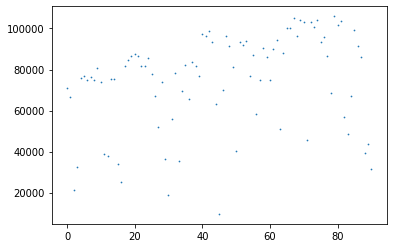

In [91]:
params = {'tree_method':'gpu_hist','gpu_id':0,"objective":"reg:squarederror",'booster': 'dart', 'lambda': 9.367121129908102e-08, 'alpha': 2.4923435220616885e-08, 'max_depth': 7, 'eta': 1.4853885138685323e-06, 'gamma': 8.53464226674219e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.029695567573807306, 'skip_drop': 1.1540510640651016e-05}

model = Model(**params)

cols = np.arange(len(keys))
cols = np.delete(cols, [0,7]) # 풍향, 강수확률 제거
_X = select_features(X, cols)

model.fit(_X, y)

_X_test = select_features(X_test, cols)
y_pred = model.predict(_X_test)
if SCALE:
    y_pred *= y_max
y_pred = y_pred.astype(int)

plt.scatter(np.arange(len(y_pred)), y_pred, s=.5)
plt.show()

In [92]:
submission['number_of_rentals'] = y_pred

In [93]:
submission.to_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/xgb_final.csv', index= False)